<a href="https://www.kaggle.com/code/hawaabdalla/k-prototypes-customer-segmentation?scriptVersionId=116971235" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import warnings
warnings.filterwarnings("ignore")
from kmodes.kprototypes import KPrototypes

##### Overview of the dataset

In [4]:
data1 = pd.read_csv("/kaggle/input/customer-segmentation/Train.csv")
data2 = pd.read_csv("/kaggle/input/customer-segmentation/Test.csv")
data= pd.concat([data1,data2], axis=0)
print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (10695, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB
None


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


##### Data Cleaning: Removing duplicates

In [6]:
data.duplicated()
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10657 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10657 non-null  int64  
 1   Gender           10657 non-null  object 
 2   Ever_Married     10468 non-null  object 
 3   Age              10657 non-null  int64  
 4   Graduated        10557 non-null  object 
 5   Profession       10495 non-null  object 
 6   Work_Experience  9567 non-null   float64
 7   Spending_Score   10657 non-null  object 
 8   Family_Size      10210 non-null  float64
 9   Var_1            10549 non-null  object 
 10  Segmentation     10657 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 999.1+ KB


##### Data Cleaning: Dropping columns with Feature leakage and High Cardinality

In [8]:
data.drop(["ID","Var_1","Segmentation"], axis="columns",inplace=True)
data.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0


##### Inspecting the categorical variables and numerical variables
##### Unique values in the features

In [10]:
print(data.select_dtypes("object").nunique())
print(data.describe())

Gender            2
Ever_Married      2
Graduated         2
Profession        9
Spending_Score    3
dtype: int64
                Age  Work_Experience   Family_Size
count  10657.000000      9567.000000  10210.000000
mean      43.537956         2.624334      2.843781
std       16.769600         3.393428      1.536758
min       18.000000         0.000000      1.000000
25%       30.000000         0.000000      2.000000
50%       41.000000         1.000000      2.000000
75%       53.000000         4.000000      4.000000
max       89.000000        14.000000      9.000000


##### Imputation method:
All except Gender, Age and Spending_Score have missing values
I shall replace missing values in categorical features with each of their modes, and numerical features with each of their median. Median is used instead of mean as it is not affected by outliers or extremes.

In [11]:
data.isna().sum()

Gender                0
Ever_Married        189
Age                   0
Graduated           100
Profession          162
Work_Experience    1090
Spending_Score        0
Family_Size         447
dtype: int64

##### Visualizing modes for the categorical columns

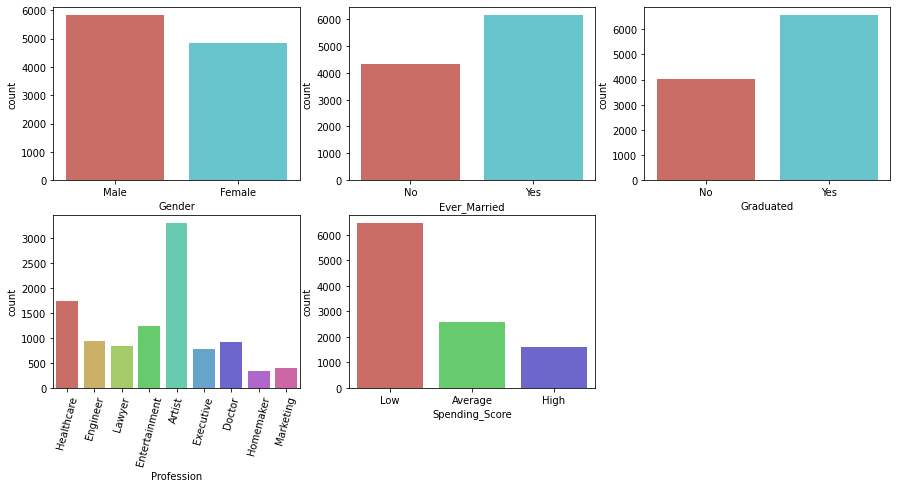

In [13]:
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
sns.countplot('Gender', data = data, palette='hls')
plt.subplot(2,3,2)
sns.countplot('Ever_Married', data = data, palette='hls')
plt.subplot(2,3,3)
sns.countplot('Graduated', data = data, palette='hls')
plt.subplot(2,3,4)
sns.countplot('Profession', data = data, palette='hls')
plt.xticks(rotation = 75)
plt.subplot(2,3,5)
sns.countplot('Spending_Score', data = data, palette='hls')
plt.show();


##### Replacing the NA's in categorical columns with their modes

In [14]:
data['Ever_Married'] = data['Ever_Married'].fillna(data['Ever_Married'].mode()[0])
data['Graduated'] = data['Graduated'].fillna(data['Graduated'].mode()[0])
data['Profession'] = data['Profession'].fillna(data['Profession'].mode()[0])

##### Replacing the NA's in numerical columns with their medians

In [15]:
data['Work_Experience'] = data['Work_Experience'].fillna(data['Work_Experience'].median())
data['Family_Size'] = data['Family_Size'].fillna(data["Family_Size"].median()) 

##### Finally,the data has no missing values

In [18]:
data.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

##### Get positions for categorical columns

In [19]:
Columnspos= [data.columns.get_loc(col) for col in list(data.select_dtypes("object").columns)]
print("Categorical columns :{}".format(list(data.select_dtypes("object").columns)))
print("Categorical columns Position :{}".format(Columnspos))

Categorical columns :['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']
Categorical columns Position :[0, 1, 3, 4, 6]


##### Standardizing data: All the numerical columns on the same scale

In [20]:
columns_to_normalize     = ['Work_Experience','Family_Size','Age']
data[columns_to_normalize] = data[columns_to_normalize].apply(lambda x: (x - x.mean()) / np.std(x))
data.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,-1.284406,No,Healthcare,-0.448331,Low,0.787274
1,Female,Yes,-0.330253,Yes,Engineer,-0.448331,Average,0.126594
2,Female,Yes,1.399148,Yes,Engineer,-0.448331,Low,-1.194767
3,Male,Yes,1.399148,Yes,Lawyer,-0.755787,High,-0.534087
4,Female,Yes,-0.210984,Yes,Entertainment,-0.448331,High,2.108635


##### Converting the dataset into matrix

In [21]:
data_matrix = data.to_numpy()
data_matrix

array([['Male', 'No', -1.2844055068336668, ..., -0.44833132883450244,
        'Low', 0.7872743047511633],
       ['Female', 'Yes', -0.3302533185305162, ..., -0.44833132883450244,
        'Average', 0.12659375779997437],
       ['Female', 'Yes', 1.3991475227689445, ..., -0.44833132883450244,
        'Low', -1.1947673361024036],
       ...,
       ['Female', 'No', 0.5642643580036876, ..., -0.44833132883450244,
        'Low', -0.5340867891512147],
       ['Male', 'Yes', 0.2064572873900061, ..., -0.44833132883450244,
        'High', 1.4479548517023524],
       ['Female', 'No', -0.032080759685781585, ..., 2.0113170476850817,
        'Low', 0.12659375779997437]], dtype=object)

##### Running the K-Prototypes algorithm

In [22]:
cost = []
for cluster in range(1,15):
    try:
        model = KPrototypes(n_jobs = -1, n_clusters=cluster, init="Huang", random_state=42)
        model.fit_predict(data_matrix, categorical= Columnspos)
        cost.append(model.cost_)
        print("Cluster Initiation: {}".format(cluster))
    except:
        break
        



Cluster Initiation: 1
Cluster Initiation: 2
Cluster Initiation: 3
Cluster Initiation: 4
Cluster Initiation: 5
Cluster Initiation: 6
Cluster Initiation: 7
Cluster Initiation: 8
Cluster Initiation: 9
Cluster Initiation: 10
Cluster Initiation: 11
Cluster Initiation: 12
Cluster Initiation: 13
Cluster Initiation: 14


##### Converting the results into a DataFrame

In [23]:
data_cost = pd.DataFrame({"Cluster":range(1,15),"Cost":cost})
data_cost.head()

,Cluster,Cost
0,1,44243.000000
1,2,34376.129634
2,3,26220.829484
3,4,22409.751866
4,5,19631.362526


##### Elbow method:
To determine the optimal number of clusters for K-Prototype,the elbow method is used.It is a backnone to a well formed clustering algorithm. The method plots the value of the cost function produced by different values of k.If k increases, the average distortion decreases,making each cluster have fewer constituent instances, and the instances will be closer to their respective centroids.

However, the improvements in average distortion will decline as k increases. The value of k at which improvement in distortion declines the most is called the **elbow**, at which we should stop dividing the data into further clusters

##### Visualizing using a Scree plot
A scree plot displays the eigenvalues in a downward curve, from the largest to the smallest.
From the figure below we can pick cluster k=4 as the optimal number of clusters,ie the point at the "elbow" or the point at which the cost start decreasing in a linear fashion.
.

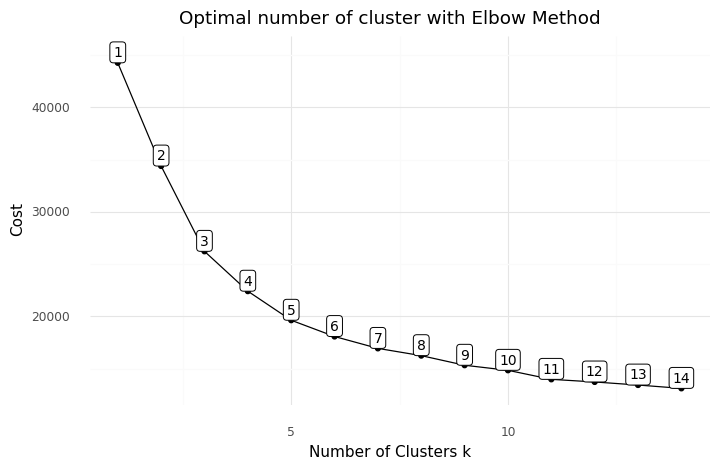

<ggplot: (8747900864361)>

In [29]:
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = data_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [31]:
model= KPrototypes(n_jobs= -1, n_clusters= 4, init= "Huang",random_state=42)
model.fit_predict(data_matrix, categorical= Columnspos)

array([3, 2, 1, ..., 2, 3, 0], dtype=uint16)

##### Getting the Cluster Centroids. 
For the numerical features it'll use the average while the categorical features use the mode.


In [32]:
model.cluster_centroids_

array([['-0.36477856218621596', '1.8306962521161878',
        '-0.2771002706378704', 'Female', 'No', 'Yes', 'Artist', 'Low'],
       ['1.5761154271448528', '-0.45963162268844066',
        '-0.4416861207710178', 'Male', 'Yes', 'Yes', 'Lawyer', 'Low'],
       ['-0.17545704188943073', '-0.45133529607499046',
        '-0.39175160536739295', 'Male', 'Yes', 'Yes', 'Artist', 'Low'],
       ['-0.7504680383387147', '-0.34029279066245927',
        '1.2462509241050386', 'Male', 'No', 'No', 'Healthcare', 'Low']],
      dtype='<U32')

##### Adding the clusters to the DataFrame

In [33]:
data["Cluster labels"]= model.labels_
data["Segment"]= data["Cluster labels"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth"})
# Order the clusters
data["Segment"] = data["Segment"].astype("category")
data["Segment"] = data["Segment"].cat.reorder_categories(["First","Second","Third","Fourth"])

data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Cluster labels,Segment
0,Male,No,-1.284406,No,Healthcare,-0.448331,Low,0.787274,3,Fourth
1,Female,Yes,-0.330253,Yes,Engineer,-0.448331,Average,0.126594,2,Third
2,Female,Yes,1.399148,Yes,Engineer,-0.448331,Low,-1.194767,1,Second
3,Male,Yes,1.399148,Yes,Lawyer,-0.755787,High,-0.534087,1,Second
4,Female,Yes,-0.210984,Yes,Entertainment,-0.448331,High,2.108635,3,Fourth
